In [1]:
import cira 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "INTC"
SYM_HIST_FILE = f'./{SYMBOL.replace("/", "_")}.csv'

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 5, 1)
    end = datetime.now().date()
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,INTC,26.78,26.88,26.45,26.87,32165978.0,122840.0,26.70
2016-01-05 05:00:00+00:00,INTC,26.84,26.88,26.50,26.74,17905707.0,87505.0,26.67
2016-01-06 05:00:00+00:00,INTC,26.28,26.50,25.93,26.15,26939523.0,121984.0,26.22
2016-01-07 05:00:00+00:00,INTC,25.52,26.09,25.17,25.17,41368839.0,163862.0,25.48
2016-01-08 05:00:00+00:00,INTC,25.37,25.47,24.84,24.91,32404640.0,142641.0,25.15


<Axes: xlabel='timestamp'>

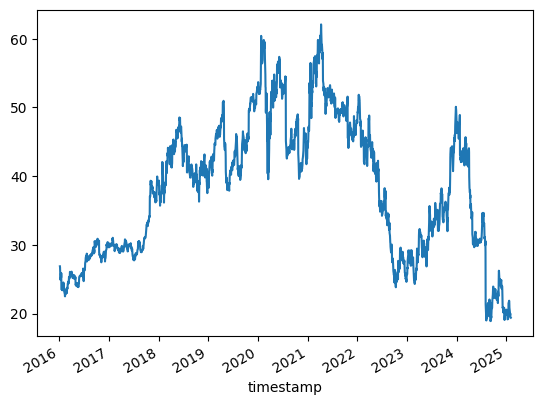

In [2]:
data['close'].plot()

In [52]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.compose import ColumnTransformer

data["volatility"] = data["close"].pct_change().rolling(window=10).std()
data["mva_10"] = data["close"].rolling(window=10).mean()
data["mva_30"] = data["close"].rolling(window=30).mean()
data.dropna(inplace=True)

def create_labels(price, window=10, threshold=0.005):
    delta = price.shift(-window) - price
    delta_pct = delta / price
    return np.where(delta_pct > threshold, "buy", np.where(delta_pct < -threshold, "sell", "hold"))
 

data["rebalance_action"] = create_labels(data["close"], window=15, threshold=0.025)


In [53]:
data["rebalance_action"].value_counts()

rebalance_action
buy     762
sell    677
hold    604
Name: count, dtype: int64

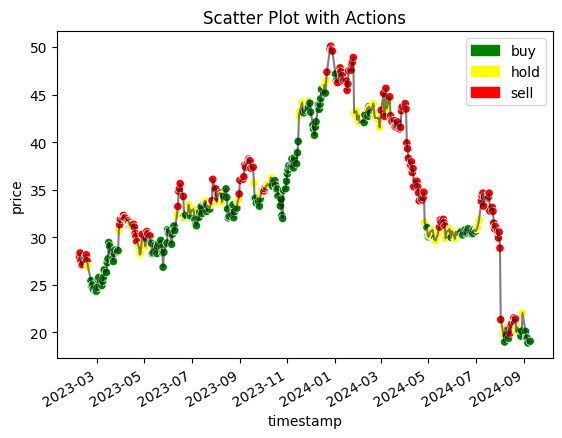

In [56]:
import matplotlib.patches as mpatches

data_reset = data.copy()
data_reset = data[-500:-100].copy()
data_reset["timestamp"] = data_reset.index
data_reset["action_enum"] = data_reset["rebalance_action"].apply(lambda x: 1 if x == "buy" else -1 if x == "sell" else 0)
sns.scatterplot(data=data_reset, x=data_reset["timestamp"], y=data_reset["close"], hue='action_enum', palette={-1: 'red', 0: 'yellow', 1: 'green'})
data_reset["close"].plot(color='black', alpha=0.5)
plt.title('Scatter Plot with Actions')
plt.xlabel('timestamp')
plt.ylabel('price')
legend_handles = [
    mpatches.Patch(color='green', label='buy'),
    mpatches.Patch(color='yellow', label='hold'),
    mpatches.Patch(color='red', label='sell'),
]
plt.legend(handles=legend_handles)
plt.show()
